# Hill-Valley Data Set

**Data Set Information:**

Each record represents 100 points on a two-dimensional graph. When plotted in order (from 1 through 100) as the Y coordinate, the points will create either a Hill (a “bump” in the terrain) or a Valley (a “dip” in the terrain).

**Attribute Information:**

1-100: Labeled “X##”. Floating point values (numeric)

101: Labeled “class”. Binary {0, 1} representing {valley, hill}

In [1]:
# input reading
setwd("C:/IE582")
Dataset_2<-read.table("Hill_Valley.data",sep=",",header=T)
colnames(Dataset_2)[101]="Class"
Dataset_2$Class<-as.factor(Dataset_2$Class)
str(Dataset_2)

'data.frame':	606 obs. of  101 variables:
 $ X1   : num  1317.27 7329.97 809.42 45334.21 1.81 ...
 $ X2   : num  1315.22 7379.91 809.78 45334.21 1.81 ...
 $ X3   : num  1312.77 7441.8 810.21 45334.22 1.81 ...
 $ X4   : num  1309.83 7518.5 810.72 45334.23 1.81 ...
 $ X5   : num  1306.32 7613.57 811.32 45334.23 1.81 ...
 $ X6   : num  1302.1 7731.38 812.04 45334.24 1.81 ...
 $ X7   : num  1297.05 7877.39 812.9 45334.25 1.81 ...
 $ X8   : num  1290.99 8058.34 813.92 45334.26 1.81 ...
 $ X9   : num  1283.74 8282.6 815.14 45334.28 1.81 ...
 $ X10  : num  1275.04 8560.53 816.59 45334.3 1.81 ...
 $ X11  : num  1264.62 8904.97 818.31 45334.32 1.81 ...
 $ X12  : num  1252.14 9331.85 820.36 45334.34 1.81 ...
 $ X13  : num  1237.18 9860.9 822.81 45334.37 1.81 ...
 $ X14  : num  1219.25 10516.56 825.72 45334.4 1.81 ...
 $ X15  : num  1197.77 9860.9 829.18 45334.43 1.81 ...
 $ X16  : num  1172.02 9331.85 833.3 45334.48 1.81 ...
 $ X17  : num  1141.17 8904.97 838.21 45334.53 1.81 ...
 $ X18  : num  

In [2]:
set.seed(105) 
# select 75% of data as train data
sample <- sample.int(n = nrow(Dataset_2), size = floor(.75*nrow(Dataset_2)), replace = F)
Dataset_2_train <- Dataset_2[sample, ]
Dataset_2_test  <- Dataset_2[-sample, ]

## Penalized Regression

In the penalized regression approach, cross validation is used on the train data to find the best value of the lambda and it is found after 10 fold cross validation. Then with this lambda a model is built to predict class of the test data instances as "hill" or "valley".

In [3]:
library(glmnet)

Warning message:
"package 'glmnet' was built under R version 3.6.3"Loading required package: Matrix
Loaded glmnet 4.1


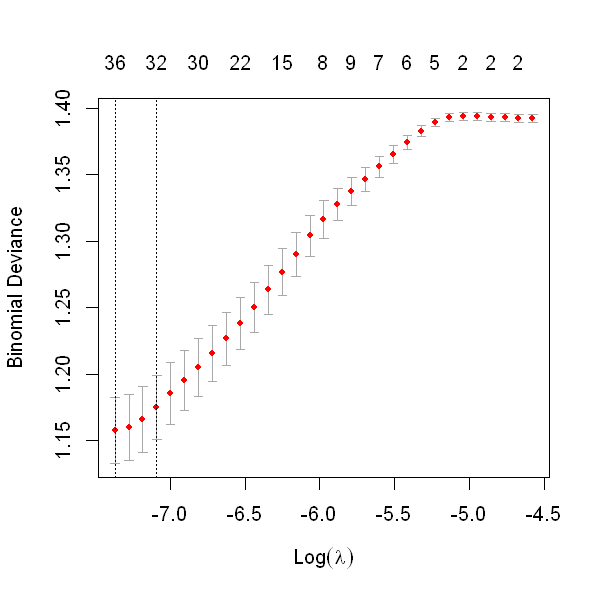

In [4]:
new_train<-as.matrix(Dataset_2_train[,-101])
new_test<-as.matrix(Dataset_2_test[,-101])
cross_validation<-cv.glmnet(new_train,as.matrix(Dataset_2_train$Class) ,family="binomial", alpha=1)
options(repr.plot.width=5, repr.plot.height=5)
plot(cross_validation)

In [5]:
print(c("The best lambda value: ", cross_validation$lambda.min))

[1] "The best lambda value: " "0.000631152887902228"   


- **The best lambda value is found as 0.00063.**

In [6]:
# fitting the penalized regression model
fit <- glmnet(new_train,as.matrix(Dataset_2_train$Class) ,family="binomial", alpha=1,lambda=cross_validation$lambda.min)
# summarize the model
summary(fit)

           Length Class     Mode     
a0           1    -none-    numeric  
beta       100    dgCMatrix S4       
df           1    -none-    numeric  
dim          2    -none-    numeric  
lambda       1    -none-    numeric  
dev.ratio    1    -none-    numeric  
nulldev      1    -none-    numeric  
npasses      1    -none-    numeric  
jerr         1    -none-    numeric  
offset       1    -none-    logical  
classnames   2    -none-    character
call         6    -none-    call     
nobs         1    -none-    numeric  

In [7]:
# prediction for train data
predictions <- predict(fit, new_train, type="class")
# accuracy for train data
tab<-table(predictions[,1],Dataset_2_train$Class)
print("confusion matrix for the train data:")
print(tab)
train_error<-1-sum(diag(tab)/sum(tab))
print(c("train error:",train_error))

[1] "confusion matrix for the train data:"
   
      0   1
  0 115   0
  1 111 228
[1] "train error:"      "0.244493392070485"


In [8]:
# prediction for test data
predictions <- predict(fit, new_test, type="class")
# accuracy for test data
tab<-table(predictions[,1],Dataset_2_test$Class)
print("confusion matrix for the test data:")
print(tab)
test_error<-1-sum(diag(tab)/sum(tab))
print(c("test error:",test_error))

[1] "confusion matrix for the test data:"
   
     0  1
  0 41  1
  1 38 72
[1] "test error:"       "0.256578947368421"


- Penalized regression with lasso penalty gives **train error of 0.244** and **test error of 0.257** for this data set.

## Decision Tree

In decision tree approach, for **the minimal number of observations per tree leaf** 2,3,4 and 5 are used; for **the complexity parameter** 0.005, 0.01, 0.015 and 0.02 are used.

In [9]:
require(rpart)
require(rattle)

Loading required package: rpart
Warning message:
"package 'rpart' was built under R version 3.6.3"Loading required package: rattle
Warning message:
"package 'rattle' was built under R version 3.6.3"Loading required package: tibble
Warning message:
"package 'tibble' was built under R version 3.6.3"Loading required package: bitops
Rattle: A free graphical interface for data science with R.
Version 5.4.0 Copyright (c) 2006-2020 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.


In [18]:
set.seed(154)

# function for building a decision tree with different parameters of the minimal number of observations per tree leaf and 
# the complexity parameter

decision_tree <- function(i) {
    dtree1<-rpart(Class~.,data = Dataset_2_train,control = rpart.control(minbucket = 1+i,cp=0.005*i))
    a<-as.data.frame(printcp(dtree1))

    # prediction
    predict(dtree1,Dataset_2_test)
    
    # misclassification error for train data
    tab1_train<-table(predict(dtree1,Dataset_2_train, type="class"),Dataset_2_train$Class)
    print(tab1_train)
    error1_train<-1-sum(diag(tab1_train)/sum(tab1_train))
    print(c("train error:",error1_train)) 
  
    # misclassification error for test data
    tab1_test<-table(predict(dtree1,Dataset_2_test, type="class"),Dataset_2_test$Class)
    error1_test<-1-sum(diag(tab1_test)/sum(tab1_test))
    print(c("test error:",error1_test))
    
    options(repr.plot.width=4, repr.plot.height=4)
    plotcp(dtree1)
    return(c(error1_train,error1_test))
}

In [38]:
train_err <- list()
test_err <- list()


Classification tree:
rpart(formula = Class ~ ., data = Dataset_2_train, control = rpart.control(minbucket = 1 + 
    i, cp = 0.005 * i))

Variables actually used in tree construction:
 [1] X1  X15 X19 X22 X23 X25 X29 X36 X37 X39 X40 X44 X46 X48 X51 X55 X59 X62 X64
[20] X67 X69 X7  X74 X75

Root node error: 226/454 = 0.4978

n= 454 

         CP nsplit rel error  xerror     xstd
1 0.0376106      0   1.00000 1.07080 0.047037
2 0.0110619      2   0.92478 1.08407 0.046992
3 0.0088496     30   0.47788 1.01327 0.047138
4 0.0066372     44   0.34071 0.96903 0.047111
5 0.0058997     46   0.32743 0.97788 0.047124
6 0.0050000     49   0.30973 0.97788 0.047124
   
      0   1
  0 209  53
  1  17 175
[1] "train error:"      "0.154185022026432"
[1] "test error:"       "0.361842105263158"


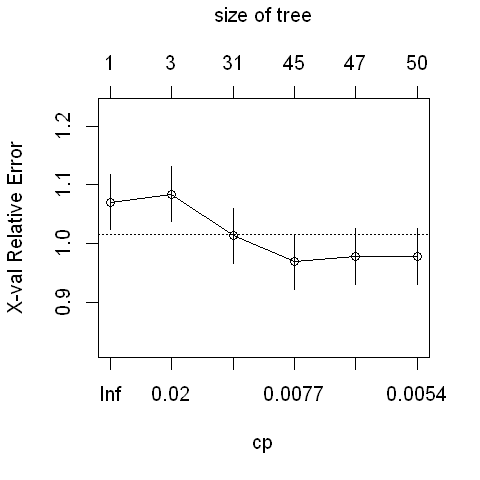

In [39]:
err = decision_tree(1)
train_err <- append(train_err,err[1])
test_err <- append(test_err,err[2])


Classification tree:
rpart(formula = Class ~ ., data = Dataset_2_train, control = rpart.control(minbucket = 1 + 
    i, cp = 0.005 * i))

Variables actually used in tree construction:
 [1] X1  X19 X22 X23 X25 X29 X37 X39 X46 X48 X55 X69 X74 X75

Root node error: 226/454 = 0.4978

n= 454 

        CP nsplit rel error xerror     xstd
1 0.037611      0   1.00000 1.1150 0.046853
2 0.011062      2   0.92478 1.1150 0.046853
3 0.010000     30   0.47788 1.0619 0.047063
   
      0   1
  0 183  65
  1  43 163
[1] "train error:"      "0.237885462555066"
[1] "test error:"       "0.434210526315789"


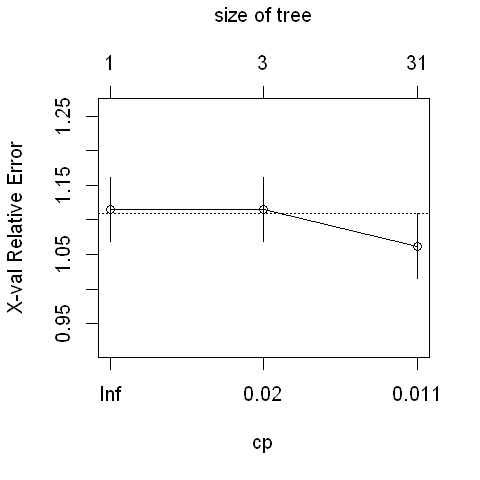

In [40]:
err = decision_tree(2)
train_err <- append(train_err,err[1])
test_err <- append(test_err,err[2])


Classification tree:
rpart(formula = Class ~ ., data = Dataset_2_train, control = rpart.control(minbucket = 1 + 
    i, cp = 0.005 * i))

Variables actually used in tree construction:
[1] X1  X69

Root node error: 226/454 = 0.4978

n= 454 

        CP nsplit rel error xerror     xstd
1 0.037611      0   1.00000 1.1814 0.046402
2 0.015000      2   0.92478 1.1726 0.046475
   
      0   1
  0 217 200
  1   9  28
[1] "train error:"      "0.460352422907489"
[1] "test error:"       "0.480263157894737"


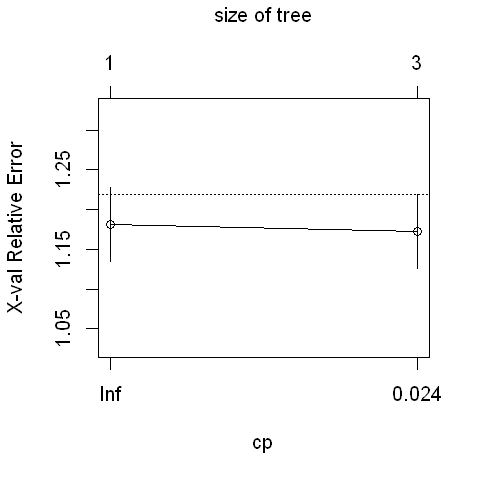

In [41]:
err = decision_tree(3)
train_err <- append(train_err,err[1])
test_err <- append(test_err,err[2])


Classification tree:
rpart(formula = Class ~ ., data = Dataset_2_train, control = rpart.control(minbucket = 1 + 
    i, cp = 0.005 * i))

Variables actually used in tree construction:
[1] X1  X69

Root node error: 226/454 = 0.4978

n= 454 

        CP nsplit rel error xerror     xstd
1 0.037611      0   1.00000 1.1504 0.046639
2 0.020000      2   0.92478 1.1504 0.046639
   
      0   1
  0 217 200
  1   9  28
[1] "train error:"      "0.460352422907489"
[1] "test error:"       "0.480263157894737"


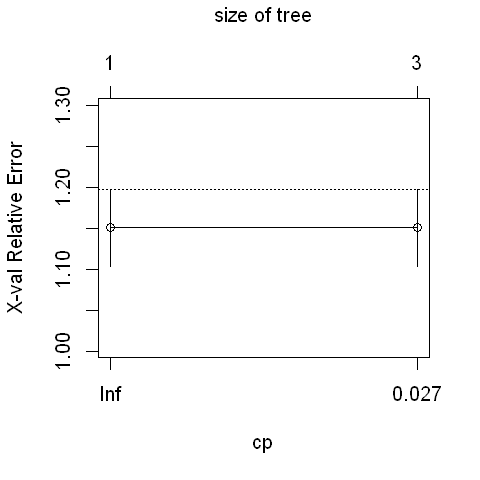

In [42]:
err = decision_tree(4)
train_err <- append(train_err,err[1])
test_err <- append(test_err,err[2])

In [43]:
train_err

[[1]]
[1] 0.154185

[[2]]
[1] 0.2378855

[[3]]
[1] 0.4603524

[[4]]
[1] 0.4603524

In [44]:
test_err

[[1]]
[1] 0.3618421

[[2]]
[1] 0.4342105

[[3]]
[1] 0.4802632

[[4]]
[1] 0.4802632

- For both train and test data the decision tree with **the minimal number of observations per tree leaf as 2** and **the complexity parameter as 0.0005** has a better performance when compared with train and test errors.

## Random Forest

In random forest approach, J trees are fit to bootstrap samples using a random sample of m features on which to split each
node. I used (12,14,16,18,20) as m in each iteration to find the best value.

In [45]:
require(randomForest)
library(cowplot)

Loading required package: randomForest
Warning message:
"package 'randomForest' was built under R version 3.6.3"randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:rattle':

    importance

Warning message:
"package 'cowplot' was built under R version 3.6.3"

In [68]:
set.seed(105)

random_forest <- function(i){
    model<-randomForest(Class~.,data=Dataset_2_train,proximity=TRUE,mtry=10+2*i)
    print(model)
    
    # misclassification error for train data
    tab1_train<-table(predict(model,Dataset_2_train, type="class"),Dataset_2_train$Class)
    print(tab1_train)
    error1_train<-1-sum(diag(tab1_train)/sum(tab1_train))
    print(c("train error:",error1_train)) 
  
    # misclassification error for test data
    tab1_test<-table(predict(model,Dataset_2_test, type="class"),Dataset_2_test$Class)
    error1_test<-1-sum(diag(tab1_test)/sum(tab1_test))
    print(c("test error:",error1_test))
    
    return(error1_test)
}

In [69]:
err <- list()

In [70]:
e = random_forest(1)
err = append(err,e)


Call:
 randomForest(formula = Class ~ ., data = Dataset_2_train, proximity = TRUE,      mtry = 10 + 2 * i) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 12

        OOB estimate of  error rate: 46.48%
Confusion matrix:
    0   1 class.error
0 121 105   0.4646018
1 106 122   0.4649123
   
      0   1
  0 226   0
  1   0 228
[1] "train error:" "0"           
[1] "test error:"       "0.368421052631579"


In [71]:
e = random_forest(2)
err = append(err,e)


Call:
 randomForest(formula = Class ~ ., data = Dataset_2_train, proximity = TRUE,      mtry = 10 + 2 * i) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 14

        OOB estimate of  error rate: 48.02%
Confusion matrix:
    0   1 class.error
0 112 114   0.5044248
1 104 124   0.4561404
   
      0   1
  0 226   0
  1   0 228
[1] "train error:" "0"           
[1] "test error:"       "0.401315789473684"


In [72]:
e = random_forest(3)
err = append(err,e)


Call:
 randomForest(formula = Class ~ ., data = Dataset_2_train, proximity = TRUE,      mtry = 10 + 2 * i) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 16

        OOB estimate of  error rate: 48.02%
Confusion matrix:
    0   1 class.error
0 114 112   0.4955752
1 106 122   0.4649123
   
      0   1
  0 226   0
  1   0 228
[1] "train error:" "0"           
[1] "test error:" "0.375"      


In [73]:
e = random_forest(4)
err = append(err,e)


Call:
 randomForest(formula = Class ~ ., data = Dataset_2_train, proximity = TRUE,      mtry = 10 + 2 * i) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 18

        OOB estimate of  error rate: 47.14%
Confusion matrix:
    0   1 class.error
0 118 108   0.4778761
1 106 122   0.4649123
   
      0   1
  0 226   0
  1   0 228
[1] "train error:" "0"           
[1] "test error:"       "0.394736842105263"


In [74]:
e = random_forest(5)
err = append(err,e)


Call:
 randomForest(formula = Class ~ ., data = Dataset_2_train, proximity = TRUE,      mtry = 10 + 2 * i) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 20

        OOB estimate of  error rate: 48.24%
Confusion matrix:
    0   1 class.error
0 113 113   0.5000000
1 106 122   0.4649123
   
      0   1
  0 226   0
  1   0 228
[1] "train error:" "0"           
[1] "test error:"       "0.394736842105263"


In [75]:
err

[[1]]
[1] 0.3684211

[[2]]
[1] 0.4013158

[[3]]
[1] 0.375

[[4]]
[1] 0.3947368

[[5]]
[1] 0.3947368

- Comparing the test error rates, the best model is found with m=12 but all the train error rates are 0, this may indicate to an overfitting issue.

- With the best decision tree, test error is 0.3618 and in this approach with the best model, test error is 0.3684. Thus, decision tree performs better than random forest.

## Stochastic Gradient Boosting (SGB)


In [79]:
library(caret)
require(gbm)

Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.6.3"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin

Loading required package: gbm
Warning message:
"package 'gbm' was built under R version 3.6.3"Loaded gbm 2.1.8


Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."

,var,rel.inf
X1,X1,19.615344
X36,X36,5.168676
X38,X38,4.630071
X21,X21,3.941656
X19,X19,3.781811
X48,X48,3.529660
X77,X77,2.908769
X72,X72,2.637949
X39,X39,2.406402
X11,X11,2.347055


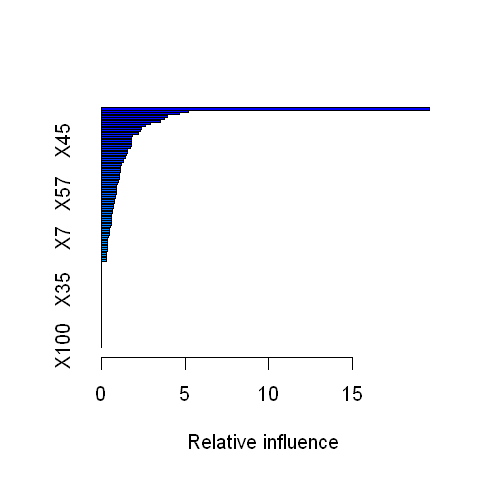

In [82]:
set.seed(123)
gbm_tree<-gbm(Class~.,data = Dataset_2_train,distribution="multinomial")
summary(gbm_tree)

In [83]:
p<-as.data.frame(predict(gbm_tree,type = "response",n.trees = 100))
predictions<-as.data.frame(matrix(nrow = nrow(Dataset_2_train),ncol = 1))
for (i in 1:nrow(predictions)){
  if (p[i,1]>p[i,2]) {predictions[i,1]=0
  }
  else {predictions[i,1]=1
  }
}
tab<-table(predictions[,1],Dataset_2_train[,101])
train_error<-1-sum(diag(tab)/sum(tab))
print(c("train error:",train_error))

[1] "train error:"      "0.314977973568282"


In [84]:
p1<-as.data.frame(predict(gbm_tree,Dataset_2_test, type = "response",n.trees = 100))
predictions<-as.data.frame(matrix(nrow = nrow(Dataset_2_test),ncol = 1))
for (i in 1:nrow(predictions)){
  if (p1[i,1]>p1[i,2]) {predictions[i,1]=0
  }
  else {predictions[i,1]=1
  }
}
tab<-table(predictions[,1],Dataset_2_test[,101])
test_error<-1-sum(diag(tab)/sum(tab))
print(c("test error:",test_error))

[1] "test error:"       "0.407894736842105"


- Test error is found as *0.4079* in this approach.
- In the penalized regression with Lasso penalty, test error is *0.2566*.
- In the decision tree with the best model, test error is *0.3618* 
- In the random forest with the best model, test error is *0.3684*.


- Thus considering the error rates, **the penalized regression with Lasso penalty performs better than other approaches.**